<a href="https://colab.research.google.com/github/alexvadelgado/Barberia/blob/main/Modelo_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os

from google.colab import files

## Preparación de los Datos

# Cargamos y Limpiamos el Dataset

Cargamos Archivo train2.csv

In [2]:
uploaded = files.upload()

# Cargar el archivo directamente usando el nombre como string
train_df = pd.read_csv('train2.csv')

# Eliminar filas con valores nulos
train_df = train_df.dropna()

# Filtrar outliers
train_df = train_df[
    (train_df["fare_amount"] >= 1) &
    (train_df["fare_amount"] <= 500) &
    (train_df["pickup_latitude"].between(40, 42)) &
    (train_df["pickup_longitude"].between(-75, -72)) &
    (train_df["passenger_count"] >= 1)
]

Saving train2.csv to train2.csv


In [3]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1






*   Cálculamos las distancias usando la fórmula de Haversine.

*   Extraemos componentes de fecha/hora




In [4]:
# Función para calcular distancia (Haversine)
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Radio de la Tierra en km

# Aplicar al dataset
train_df["trip_distance"] = haversine(
    train_df["pickup_longitude"],
    train_df["pickup_latitude"],
    train_df["dropoff_longitude"],
    train_df["dropoff_latitude"]
)

# Extraer componentes de fecha/hora
train_df["pickup_datetime"] = pd.to_datetime(train_df["pickup_datetime"])
train_df["hour"] = train_df["pickup_datetime"].dt.hour
train_df["weekday"] = train_df["pickup_datetime"].dt.weekday

In [5]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,hour,weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,17,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,16,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,0,3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,4,5
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,7,1


## Entrenamiento del Modelo

# Dividir Datos en Entrenamiento y Validación

In [6]:
from sklearn.model_selection import train_test_split

# Definir variables de entrada y objetivo
X = train_df[["trip_distance", "hour", "weekday", "passenger_count"]]
y = train_df["fare_amount"]

# Dividir en 80% entrenamiento, 20% validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar y Entrenar XGBoost

In [7]:
import xgboost as xgb

# Configurar el modelo
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,      # Número de árboles
    max_depth=5,           # Profundidad máxima de cada árbol
    learning_rate=0.1,     # Tasa de aprendizaje
    subsample=0.8,         #% de datos usados en cada árbol
    random_state=42,       # Semilla para reproducibilidad
    n_jobs=-1              # Usar todos los núcleos del CPU
)

# Entrenar
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
# Para una prediccion seria necesitamos un score por encima de 0.9
model_score = model.score(X_train, y_train)
print("Precisión del modelo en el conjunto de entrenamiento:", model_score)

Precisión del modelo en el conjunto de entrenamiento: 0.7317912883962256


## Generar Predicciones

# Evaluar en Validación

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predecir en validación
val_preds = model.predict(X_val)

# Calcular MSE
mse = mean_squared_error(y_val, val_preds)

# Calcular RMSE tomando la raíz cuadrada del MSE
rmse = np.sqrt(mse)
print(f"RMSE en validación: {rmse:.2f} USD")


RMSE en validación: 4.92 USD


# Predecir en el Conjunto de Test de Kaggle

In [10]:
from google.colab import files
uploaded = files.upload()
test_df = pd.read_csv('test.csv')

# Aplicar mismo preprocesamiento
test_df["trip_distance"] = haversine(
    test_df["pickup_longitude"],
    test_df["pickup_latitude"],
    test_df["dropoff_longitude"],
    test_df["dropoff_latitude"]
)
test_df["hour"] = pd.to_datetime(test_df["pickup_datetime"]).dt.hour
test_df["weekday"] = pd.to_datetime(test_df["pickup_datetime"]).dt.weekday

# Seleccionar características
X_test = test_df[["trip_distance", "hour", "weekday", "passenger_count"]]

# Predecir
test_preds = model.predict(X_test)

# Guardar predicciones
submission = pd.DataFrame({
    "key": test_df["key"],
    "fare_amount": test_preds
})
submission.to_csv("submission.csv", index=False)

Saving test.csv to test.csv


In [11]:
# Cargar datos de predicciones
file_path = '/content/submission.csv'
test_preds = pd.read_csv(file_path)

test_preds.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.666122
1,2015-01-27 13:08:24.0000003,9.851225
2,2011-10-08 11:53:44.0000002,4.509480
3,2012-12-01 21:12:12.0000002,7.853568
4,2012-12-01 21:12:12.0000003,15.038848


## Visualización de Resultados

# Comparar Predicciones vs Reales

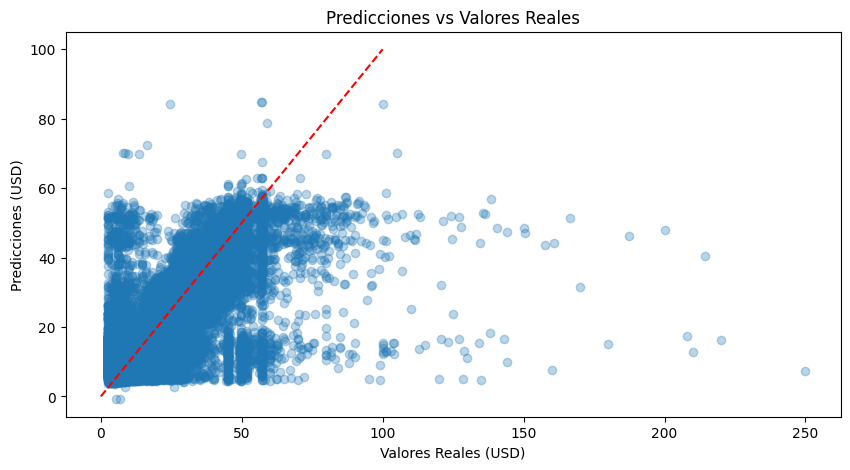

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_val, val_preds, alpha=0.3)
plt.plot([0, 100], [0, 100], "r--")  # Línea de referencia perfecta
plt.xlabel("Valores Reales (USD)")
plt.ylabel("Predicciones (USD)")
plt.title("Predicciones vs Valores Reales")
plt.show()

# Importancia de Características

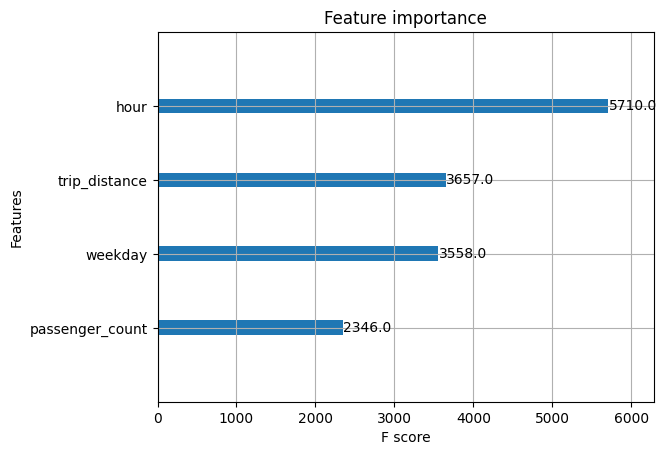

In [13]:
xgb.plot_importance(model)
plt.show()

In [14]:
import pandas as pd

# Solicitar al usuario los datos necesarios
trip_distance = float(input("Distancia (km): "))
pickup_dt = input("Datetime (YYYY-MM-DD HH:MM:SS): ")  #Ejemplo:  2023-01-01 14:30:00
passenger_count = int(input("Número de pasajeros: "))

# Convertir la fecha y hora
dt = pd.to_datetime(pickup_dt)
hour = dt.hour
weekday = dt.weekday()

# Crear el DataFrame de entrada
input_data = pd.DataFrame([{
    "trip_distance": trip_distance,
    "hour": hour,
    "weekday": weekday,
    "passenger_count": passenger_count
}])

# Realizar la predicción (asegúrate de tener el modelo cargado)
prediction = model.predict(input_data)[0]
print(f"La predicción para la tarifa del viaje es: ${prediction:.2f}")


Distancia (km): 10
Datetime (YYYY-MM-DD HH:MM:SS): 2023-01-01 14:30:00
Número de pasajeros: 3
La predicción para la tarifa del viaje es: $32.01


# Guardamos el modelo entrenado

In [15]:
import joblib
modelo_entrenado = model.fit(X_train, y_train)
joblib.dump(modelo_entrenado, 'modelo_taxi.pkl')

['modelo_taxi.pkl']

# Cargamos el modelo Guardado

In [16]:
modelo_cargado = joblib.load('modelo_taxi.pkl')
modelo_cargado

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

### Explicación Técnica

**Entrenamiento:**  
XGBoost construye árboles de decisión secuenciales. Cada árbol intenta corregir los errores residuales del anterior, optimizando una función de pérdida (en este caso, error cuadrático).

**Predicción:**  
Para un nuevo viaje, el modelo suma las predicciones de todos los árboles, ponderadas por la tasa de aprendizaje (`learning_rate`), para estimar la tarifa.

**Hiperparámetros clave:**

- `n_estimators`: Más árboles mejoran la precisión, pero aumentan el tiempo de cómputo.
- `max_depth`: Controla la complejidad del modelo (profundidad de los árboles).
- `learning_rate`: Valores bajos (ej: 0.1) evitan sobreajuste pero requieren más árboles.

---

### Posibles Mejoras

**Más características:**

- Distancia a aeropuertos, estaciones de tren, o puntos turísticos.
- Variables de tráfico histórico.

**Optimización avanzada:**

- Usar herramientas como *Optuna* para ajustar hiperparámetros automáticamente.

**Entrenar con más datos:**

- Probar con el 100% del dataset usando servicios en la nube (Google Colab Pro, AWS).

---

### Resultado Final

- **Archivo de predicciones:** `submission.csv` (listo para subir a Kaggle).  
- **RMSE esperado:** Entre **3.5 y 4.5 USD** (dependiendo de las características usadas).
